# Analyse model
This notebook does analyses of the VAR model, to quantify its meaningfulness.

In [56]:
# To make relative imports work in notebooks
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, COL_STUDENT, COL_STUDENT_PRED, COL_SALARY, COL_SALARY_PRED, FIG_DIR, COURSES, SECTORS
from src.dataLoading import getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedGrossSalaries
from src.model import fitVarModelCompleteDataset, predictWithData
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import VAR
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tueplots import bundles

In [41]:
interestingYears = YEARS[3:-4]
totalStudents = getTotalStudentsFor(courses = COURSES, years = interestingYears)

inflationAdjustedGrossSalary= getInflationAdjustedGrossSalaries(SECTORS)
salaries = getSalaries()

years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)
newVal = (graduatesInBW[4] + graduatesInBW[6])/2

/Users/maxschnitt/Documents/AnalysingStudentDevelopment/src/dataLoading.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4
/Users/maxschnitt/Documents/AnalysingStudentDevelopment/src/dataLoading.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4


### Test model accuracy
Delete the last `PREDICTION_STEPS` timesteps and use them as a test set.

In [42]:
LAGS = 5
PREDICTION_STPES = 2

In [43]:
completeData = np.column_stack((totalStudents, inflationAdjustedGrossSalary, graduatesInBW.repeat(2)))
trainData, testData = np.split(completeData, [len(completeData) - PREDICTION_STPES])
completeDataDF = pd.DataFrame(completeData, index = YEARS[3:-4], columns = ['students', 'sallary', 'graduates'])

In [44]:
results = fitVarModelCompleteDataset(completeData, LAGS)
forecast, lower, upper = predictWithData(results, trainData[-LAGS:], PREDICTION_STPES)
print(forecast)

[[ 6105.29809524  3925.12020346 44035.98918662]
 [ 6574.30468621  3975.09337557 44498.77937526]]


In [45]:
print("These are the absoulue diffrences between the predicted and the actual values")
np.set_printoptions(suppress=True)
absDiffernce = abs(forecast - testData)
print(absDiffernce)

print("\nThese are the percentage differences between the predicted and the actual values")
percentage_difference = (absDiffernce / testData) * 100
print(percentage_difference)

These are the absoulue diffrences between the predicted and the actual values
[[ 29.70190476  16.37211539  49.01081338]
 [ 89.69531379  12.12028889 413.77937526]]

These are the percentage differences between the predicted and the actual values
[[0.48413863 0.41885829 0.11117345]
 [1.34596809 0.30583828 0.93859448]]


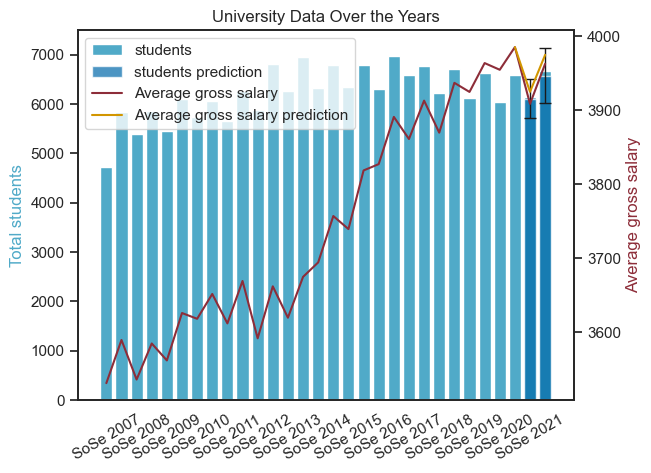

In [46]:
fig, ax1 = plt.subplots()
plt.title('University Data Over the Years')
plt.xticks(rotation=30)

ax1.set_ylabel('Total students', color=COL_STUDENT)
ax1.bar(interestingYears[:-PREDICTION_STPES], trainData[:, 0], color=COL_STUDENT, label='students')
ax1.bar(interestingYears[-PREDICTION_STPES:], testData[:, 0], color=COL_STUDENT)
ax1.bar(interestingYears[-PREDICTION_STPES:], forecast[:, 0], color=COL_STUDENT_PRED, alpha=0.7, label='students prediction')
ax1.errorbar(interestingYears[-PREDICTION_STPES:], forecast[:, 0], yerr=upper[:, 0] - lower[:, 0], fmt='none', ecolor='k', elinewidth=1, capsize=4)

ax2 = ax1.twinx()  # instantiate a second ax that shares the same x-axis
forecastWithPrevious = np.concatenate((trainData[-1, :].reshape(1, -1), forecast))

ax2.set_ylabel('Average gross salary', color=COL_SALARY)
ax2.plot(interestingYears, completeData[:, 1], color=COL_SALARY, label='Average gross salary')
ax2.plot(interestingYears[-PREDICTION_STPES -1:], forecastWithPrevious[:, 1], color=COL_SALARY_PRED, label='Average gross salary prediction')


# Create one legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Get current ticks, keep only every second tick
locs, labels = plt.xticks()
plt.xticks(locs[::2], labels[::2])
fig.savefig(FIG_DIR + f"/prediction_{LAGS}.pdf")
plt.show()

In [47]:
with open('summary.txt', 'w') as file:
    file.write(str(results.summary()))

<Axes: >

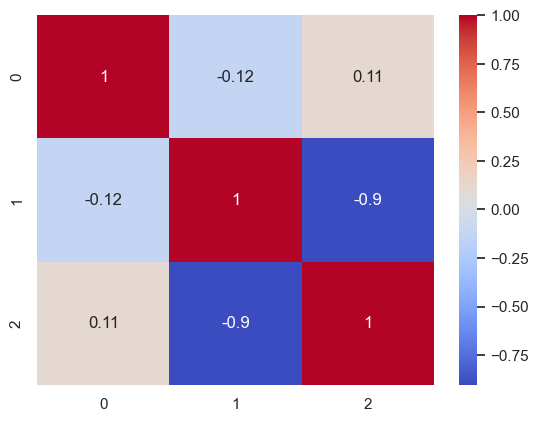

In [48]:
import seaborn as sns
resudiuals = results.resid
correlationMatrix = np.corrcoef(resudiuals, rowvar=False)
sns.set(style="white")
sns.heatmap(correlationMatrix, cmap="coolwarm", annot=True, )

## Optimization of the hyperparameter lag
The VAR model has one hyperparameter p which can be optimized. If the lag size increases the complexity of the model increases. 
We compute the percentage difference between true value and the prediction and accumulate those for each lag over all predictions. Then we plot this as a line graph and
optimize for the minimal value for the students percentage error.

In [49]:
def computePercentageDifference(forecast,testData):
    """computes percentage difference between prediction and truth value

    Args:
        forecast (np.array): predicted data
        testData (np.array): true data

    Returns:
        np.array: percentage difference between truth value and prediciton
    """
    absDiffernce = abs(forecast - testData)
    return (absDiffernce / testData) * 100

In [50]:
def computeAllPercentages():
    """compute all percentage differences for lag 1 to 6

    Returns:
        np.array: percentage differences for lag 1 to 6
    """
    percentageDifferences = []
    for lags in range(1,7):
        results = fitVarModelCompleteDataset(completeData, lags)
        forecast, lower, upper = predictWithData(results, trainData[-lags:], PREDICTION_STPES)
        percentageDifference = computePercentageDifference(forecast,testData).sum(axis=0)
        percentageDifferences.append(percentageDifference)
    return np.array(percentageDifferences)


def getStudentsDifferenceAsPercent(allPercentages):
    """get percentage difference for students 

    Args:
        allPercentages (np.array): all Predictions for lag 1 to 6

    Returns:
        np.array: percentage difference for students as 1d array
    """
    return allPercentages[:,0].transpose() / 100

def getSalaryDifferenceAsPercent(allPercentages):
    """get percentage difference for salary 

    Args:
        allPercentages (np.array): all Predictions for lag 1 to 6

    Returns:
        np.array: percentage difference for salary as 1d array
    """
    return allPercentages[:,1].transpose() / 100

def getGraduatesDifferenceAsPercent(allPercentages):
    """get percentage difference for graduates 

    Args:
        allPercentages (np.array): all Predictions for lag 1 to 6

    Returns:
        np.array: percentage difference for graduates as 1d array
    """
    return allPercentages[:,2].transpose() / 100


allPercentageDifferences = computeAllPercentages()

studentPercentageDifferences = getStudentsDifferenceAsPercent(allPercentageDifferences)
salaryPercentageDifferences = getSalaryDifferenceAsPercent(allPercentageDifferences)
graduatesPercentageDifferences = getGraduatesDifferenceAsPercent(allPercentageDifferences)

print(allPercentageDifferences/100)

[[0.06099799 0.0139086  0.05666477]
 [0.03203372 0.01307223 0.03413453]
 [0.03490697 0.01171898 0.02943187]
 [0.0193364  0.00683286 0.02722869]
 [0.01830107 0.00724697 0.01049768]
 [0.02137727 0.00782685 0.01887966]]


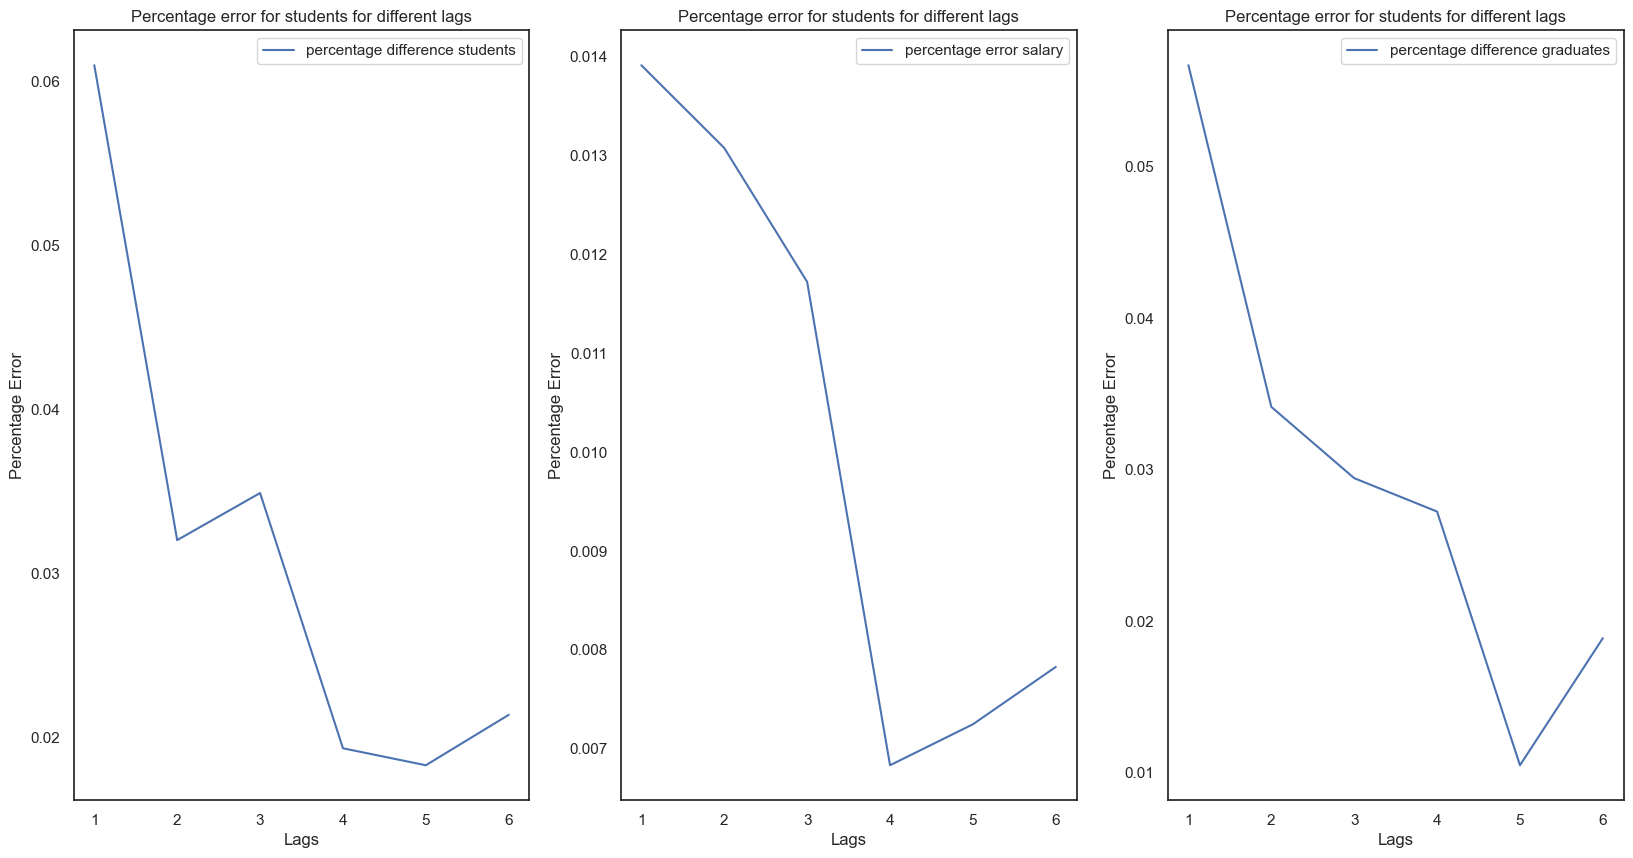

In [51]:
#plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=3, usetex=False))
fig, ax = plt.subplots(figsize=(20,10),nrows=1, ncols=3)

ax[0].set_title("Percentage error for students for different lags")
ax[0].plot(range(1,7),studentPercentageDifferences, label="percentage difference students")
ax[0].set_ylabel("Percentage Error")
ax[0].set_xlabel("Lags")
ax[0].legend();

ax[1].set_title("Percentage error for students for different lags")
ax[1].plot(range(1,7),salaryPercentageDifferences, label="percentage error salary")
ax[1].set_ylabel("Percentage Error")
ax[1].set_xlabel("Lags")
ax[1].legend();

ax[2].set_title("Percentage error for students for different lags")
ax[2].plot(range(1,7),graduatesPercentageDifferences, label="percentage difference graduates")
ax[2].set_ylabel("Percentage Error")
ax[2].set_xlabel("Lags")
ax[2].legend();

### Analysis
As you can see the predicitons of the model gets better if we increase the lag size. We choose a lag size of 5 because we are optimizing for the students, and this is the minima
for the lags in range from 1 to 6